## Data Wrangling

In [69]:
import boto3
import sagemaker
from pyathena import connect
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from geopy.geocoders import Nominatim
import geopandas
import tensorflow as tf
import scipy


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

### Create and Verify Database

In [2]:
# Make athena db
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [3]:
ingest_create_athena_db_passed = False

In [4]:
# Set db name
database_name = "crops"

In [5]:
# Set S3 staging directory - temporary directory used for athena
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [6]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [7]:
# Create the Database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS crops


""


In [8]:
# Make sure it was created
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head()

,database_name
0,crops
1,default


In [9]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Create Athena for Merged DB

In [10]:
# Athena parameters
table_name_csv = "merged_df"
s3_private_path_csv = "s3://sagemaker-studio-998234604495-nyhifbo32oo/merged/"
table_name_parquet = "merged_df_parquet"
s3_path_parquet = "s3://sagemaker-studio-998234604495-nyhifbo32oo/parquet/"


In [11]:
# Create athena table based on merged data
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        Area string,
        Item string,
        year integer,
        production integer,
        nitrogen integer,
        phosphate integer,
        potassium integer,
        value float,
        avg_rain float,
        avg_temp float,
        total_value_usd float
        
        
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_csv
)

pd.read_sql(statement, conn)

""


In [12]:
# Look at the dataset
statement = """SELECT * FROM {}.{}
    LIMIT 5""".format(
    database_name, table_name_csv
)

print(statement)

test= pd.read_sql(statement, conn)
test.head()

SELECT * FROM crops.merged_df
    LIMIT 5


,area,item,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd
0,Albania,Apples,1991,10000,22300,7700,1300,None,1485.0,15.36,None
1,Albania,Apricots,1991,1200,22300,7700,1300,None,1485.0,15.36,None
2,Albania,Barley,1991,3323,22300,7700,1300,None,1485.0,15.36,None
3,Albania,Beans dry,1991,12844,22300,7700,1300,None,1485.0,15.36,None
4,Albania,Broad beans and horse beans green,1991,0,22300,7700,1300,None,1485.0,15.36,None


# Exploratory Data Analysis

In [13]:
### Save as df to potentially save cost
statement = """SELECT * FROM {}.{}""".format(
    database_name, table_name_csv
)

df= pd.read_sql(statement, conn)

In [14]:
print("There are", df.shape[0], "rows in the data frame and", df.shape[1], "columns")

There are 113454 rows in the data frame and 11 columns


## Adding in Geographic Data
Since we're using location as a predictor, we'll need to grab the coordinates of each country. There are also regions that we'll need to delete

In [15]:
# Functions to find coordinates
geolocater = Nominatim(user_agent="geoapiExercise")
def geolocate_lat(area):
    try:
        # Center of country
        loc = geolocater.geocode(area)
        # Return coords
        return (loc.latitude)
    except:
        return np.nan
    
def geolocate_long(area):
    try:
        # Center of country
        loc = geolocater.geocode(area)
        # Return coords
        return (loc.longitude)
    except:
        return np.nan

In [16]:
# Get the coordinates and build df for them
countries = df['area'].unique()
countries = pd.Series(countries)

latitudes = countries.apply(geolocate_lat)
longitudes = countries.apply(geolocate_long)

coord = pd.DataFrame(list(zip(countries, latitudes, longitudes)),
             columns=['area', 'lat', 'long'])

In [17]:
# Merge our data
df = pd.merge(df, coord, left_on=['area'], right_on=['area'], how="inner")

## NA Analysis

In [18]:
nan_count = df.isna().sum()
print(nan_count)

area                   0
item                   0
year                   0
production          2570
nitrogen            2149
phosphate           4453
potassium           5433
value              40675
avg_rain               0
avg_temp               0
total_value_usd    40918
lat                    0
long                   0
dtype: int64


The large amount of NAs in total_value_usd appears to be from value. Likely a country not reporting in USD or based on the year. Either one would be fairly hard to get the correct value as we would need to look up the conversion rates for every country at the specific times.

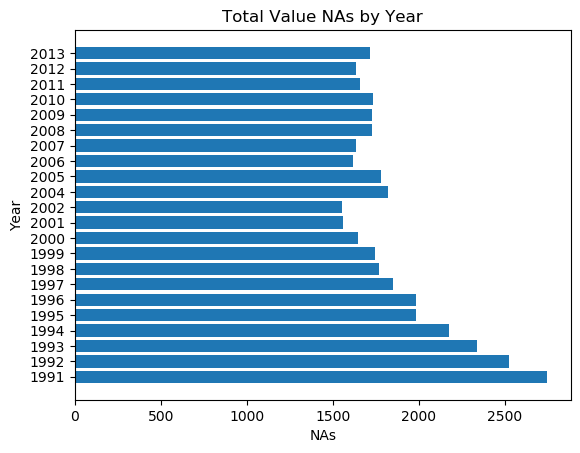

In [19]:
# By Year
na_year = df.total_value_usd.isnull().groupby(df['year']).sum().astype(int).reset_index(name="count")
na_year['year'] = na_year['year'].astype(object)

bars = na_year['year']
height = na_year['count']
y_pos = np.arange(len(bars))

plt.clf()
plt.barh(y_pos, height)

plt.title("Total Value NAs by Year")
plt.ylabel("Year")
plt.xlabel("NAs")
plt.yticks(y_pos, bars)
plt.show()

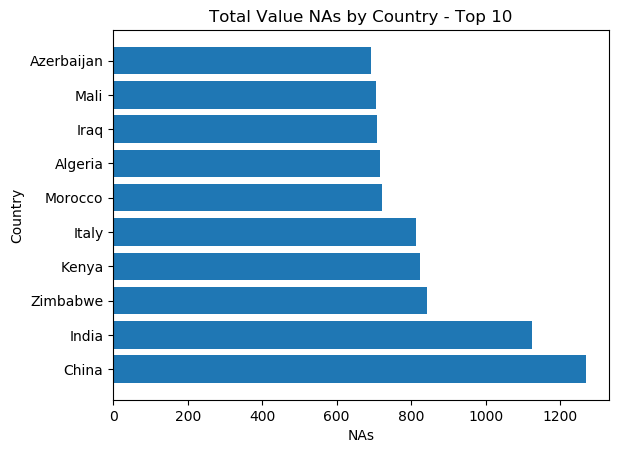

In [20]:
# By Country
na_country = df.total_value_usd.isnull().groupby(df['area']).sum().astype(int).reset_index(name="count")
na_country = na_country.sort_values(by=['count'], ascending=False).head(10)


bars = na_country['area']
height = na_country['count']
y_pos = np.arange(len(bars))

plt.clf()
plt.barh(y_pos, height)

plt.title("Total Value NAs by Country - Top 10")
plt.ylabel("Country")
plt.xlabel("NAs")
plt.yticks(y_pos, bars)
plt.show()

It looks like India may have some issues if we remove the NAs. We'll check to see how many observations are left when we remove NAs.

Looks like we'll still be fine leaving India in. 

In [21]:
df_nona = df.dropna()
df_nona_china = df_nona[df_nona['area'] == "China"]
df_china = df[df['area'] == "China"]

print("China loses", df_china.shape[0] - df_nona_china.shape[0], "observations when we take out NAs leaving us with", df_nona_china.shape[0], "observations left for the country")

China loses 1268 observations when we take out NAs leaving us with 1460 observations left for the country


### Final clean before EDA
As we'll see below, fertilizers are fairly related to each other so we should be able to impute those missing values in a pipeline later. It likely isn't appropriate to impute the large number of missing total_value_usd's, so we will delete those.

In [22]:
df_clean = df[df['total_value_usd'].notna()]

# Note - we still expect to have nas for fertilizers since we're imputing those
nan_count = df_clean.isna().sum()
print(nan_count)

area                  0
item                  0
year                  0
production            0
nitrogen            173
phosphate          1376
potassium          1615
value                 0
avg_rain              0
avg_temp              0
total_value_usd       0
lat                   0
long                  0
dtype: int64


## Target Variable - total_value_usd 
The target variable is the production (in tonnes) multiplied by the value (United States Dollar per tonne).

### Distribution 
Our target is very skewed to the right. Not suprising given that some crops likely produce a lot more value than most (for example corn in the USA is likely very high valued). Need to consider scaling after splitting.

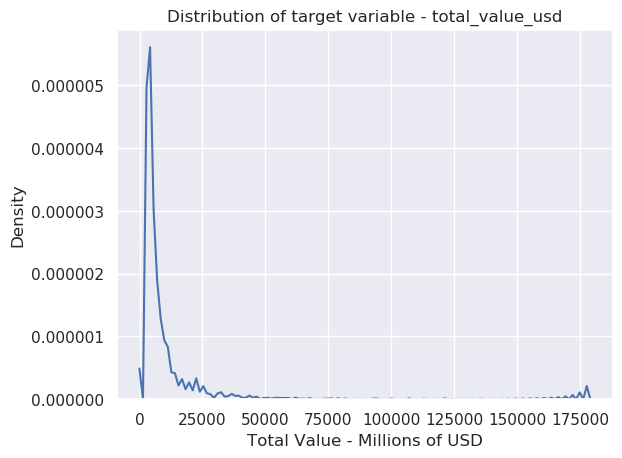

In [23]:
sns.set(style = "darkgrid")
sns.distplot(a = df_clean['total_value_usd']/1_000_000, hist = False, kde = True, rug = False)
plt.xlabel("Total Value - Millions of USD")
plt.ylabel("Density")
plt.title("Distribution of target variable - total_value_usd")
plt.show()

## Numeric Predictors 
The numeric predictors include the fertilizers used for agricultural purposes (nitrogen, phosphate, and potassium) and the weather featrues (avg_temp and avg_rain)

Fertilizer Distributions -
Still skewed heavily to the right, we'll likely need to make pipeline to standardize all numeric features

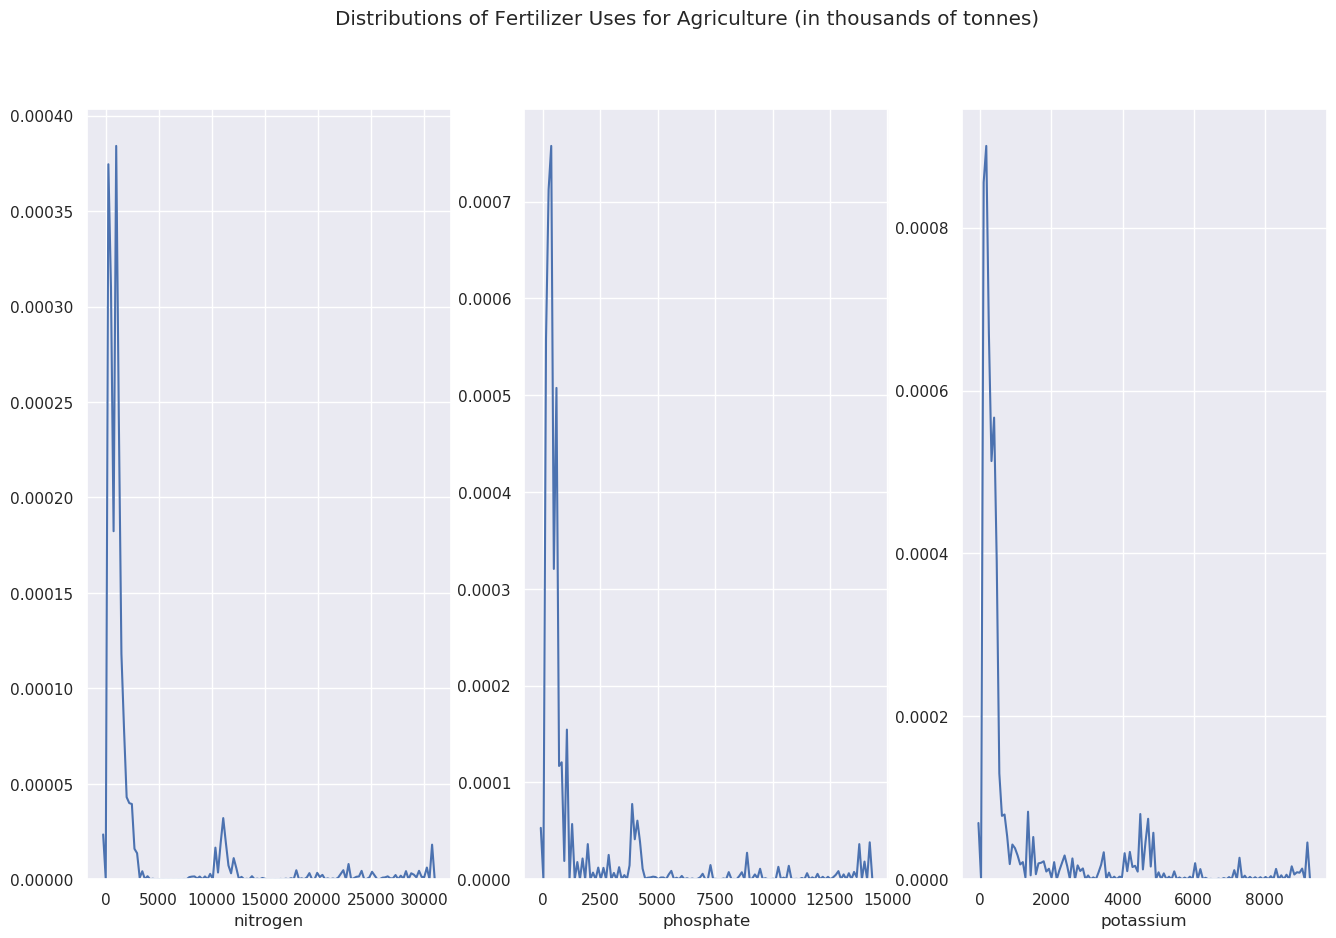

In [24]:
fig, axes = plt.subplots(1,3, figsize=(16,10))

fig.suptitle("Distributions of Fertilizer Uses for Agriculture (in thousands of tonnes)")

sns.distplot(ax = axes[0], a = df_clean['nitrogen']/1_000, hist = False, kde = True, rug = False)
sns.distplot(ax = axes[1], a = df_clean['phosphate']/1_000, hist = False, kde = True, rug = False)
sns.distplot(ax = axes[2], a = df_clean['potassium']/1_000, hist = False, kde = True, rug = False)

plt.show()


Weather Predictors - These Look a lot better than other variables, regardless a standardization pipeline that works on all numeric features is still probbaly the most efficient option.

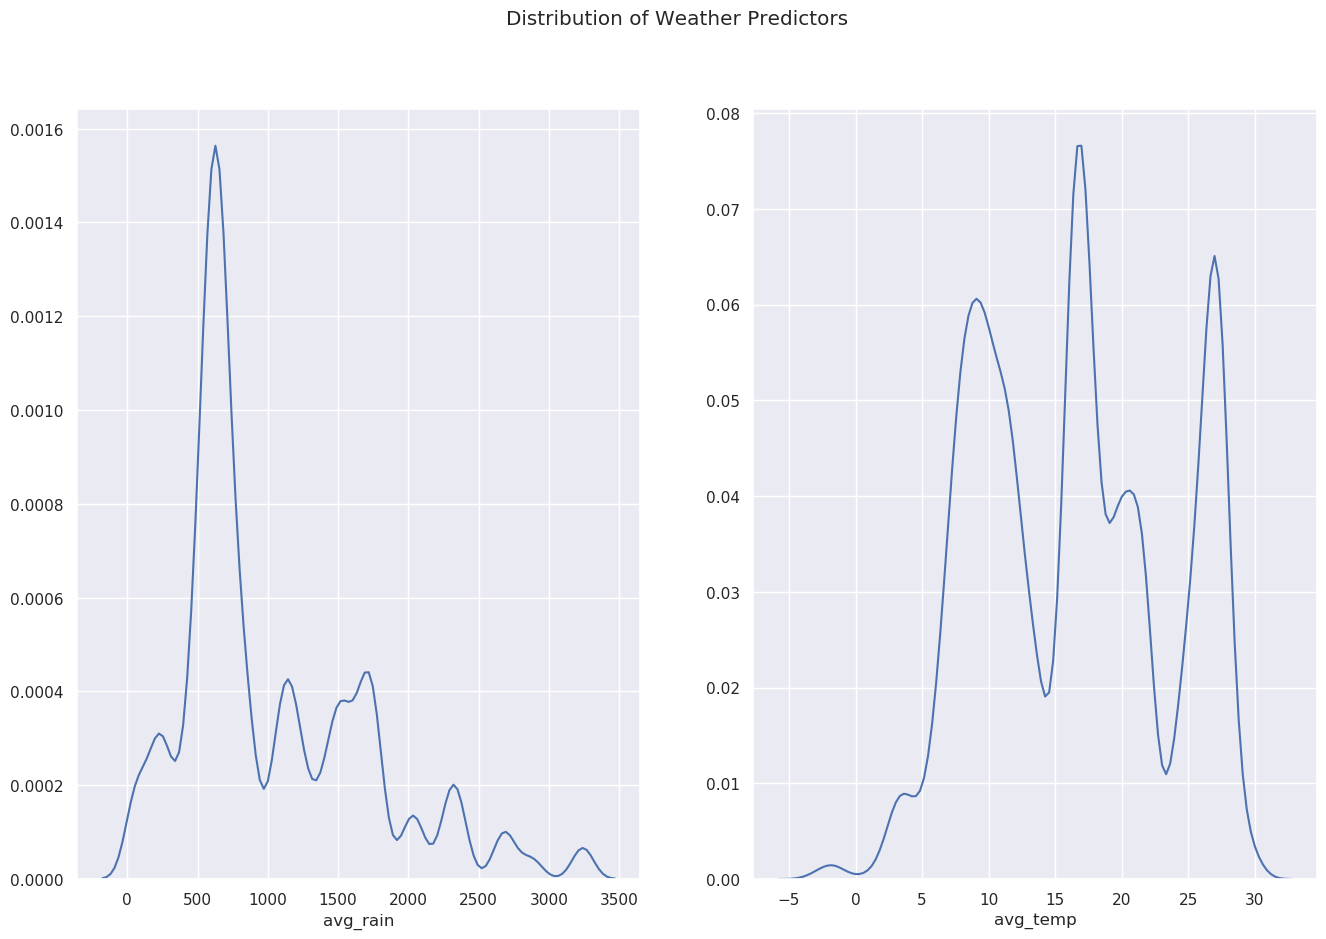

In [25]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

fig.suptitle("Distribution of Weather Predictors")

sns.distplot(ax = axes[0], a = df_clean['avg_rain'], hist = False, kde = True, rug = False)
sns.distplot(ax = axes[1], a = df_clean['avg_temp'], hist = False, kde = True, rug = False)

plt.show()

Correlation Matrix for Numeric Features

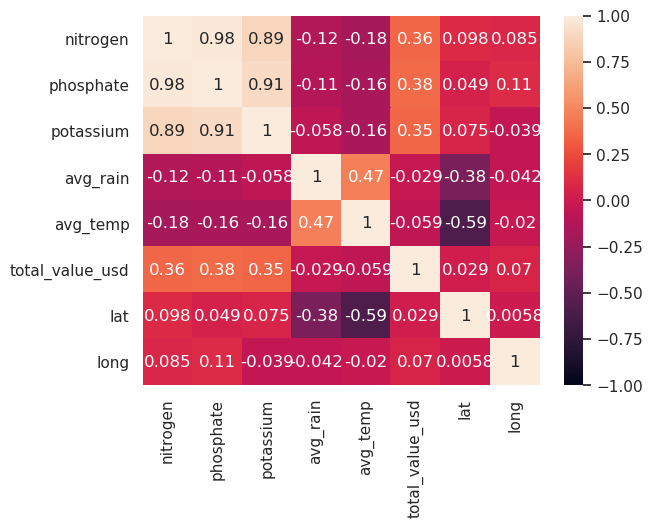

In [26]:
df_numeric = df_clean.select_dtypes(['int64', 'float64'])
df_numeric = df_numeric.drop(columns=['year', 'production', 'value'], axis=1)
df_numeric_nona = df_numeric.dropna()


plt.clf()
sns.heatmap(df_numeric_nona.corr(), vmin= -1, vmax=1, annot=True)
plt.show()

## Maps
Doing the maps down here since we have NAs sorted out now.

Bring in our world data

In [27]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

#### Fix Country names:
Some names aren't matching between world and df, need to match them since we're merging on them.

In [28]:
world['name'].unique();

In [29]:
world_country = ['United States of America', 'Dem. Rep. Congo', 'Congo']
df_country = ["United States", "Congo, Dem. Rep.", "Congo, Rep."]

world2 = world

for (old, new) in zip(world_country, df_country):
    world2['name'] = world['name'].replace(old,new)



### Highest Ag Value 1991-2013

In [30]:
val_country = df_clean.groupby(by="area")["total_value_usd"].sum()

countries = df_clean['area'].unique()
countries = pd.Series(countries)

geos = world2[['name', 'geometry']]
geos

val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_value = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [31]:
gdf_value['value'] = gdf_value[['value']]/1_000_000_000_000

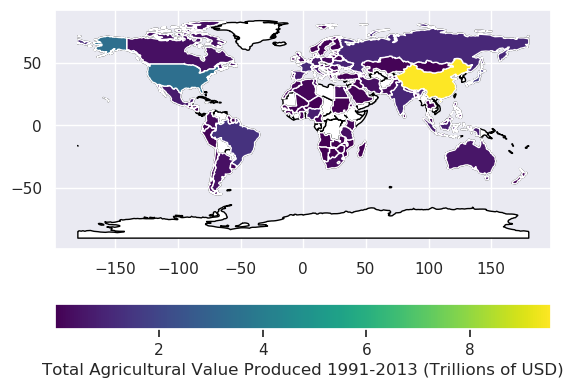

In [32]:
%%capture --no-display

base = world.plot(color = "white", edgecolor = 'black')

gdf_value.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Total Agricultural Value Produced 1991-2013 (Trillions of USD)",
                            'orientation':"horizontal"})
plt.show()

### Avg. Temperatures

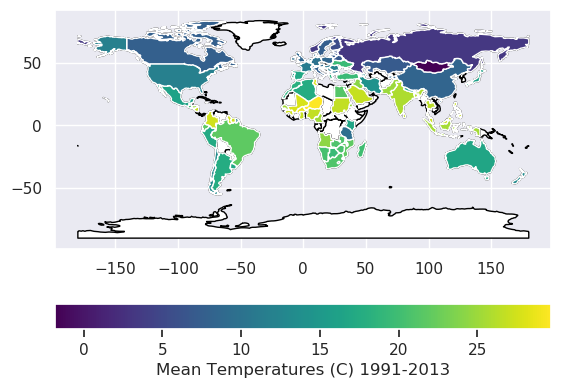

In [33]:
%%capture --no-display
# Taking mean of mean should be okay since our sample sizes are the same
val_country = df_clean.groupby(by="area")["avg_temp"].mean()


val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_temp = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)


base = world.plot(color = "white", edgecolor = 'black')

gdf_temp.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Temperatures (C) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Avg. Rainfall

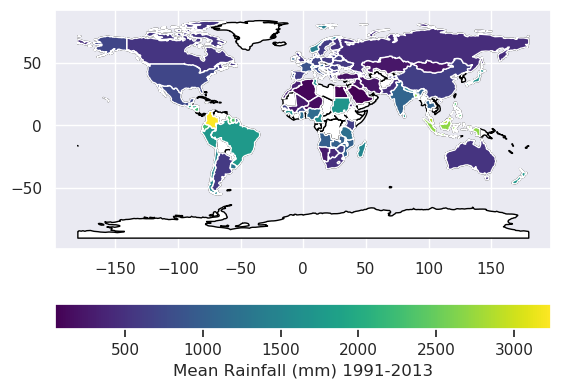

In [34]:
%%capture --no-display
# Taking mean of mean should be okay since our sample sizes are the same
val_country = df_clean.groupby(by="area")["avg_rain"].mean()

val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_rain = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)


base = world.plot(color = "white", edgecolor = 'black')

gdf_rain.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Rainfall (mm) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Nitrogen for Ag Use

In [35]:
val_country = df_clean.groupby(by="area")["nitrogen"].mean()
val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_nitrogen = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [36]:
gdf_nitrogen['value'] = gdf_nitrogen[['value']]/1_000_000

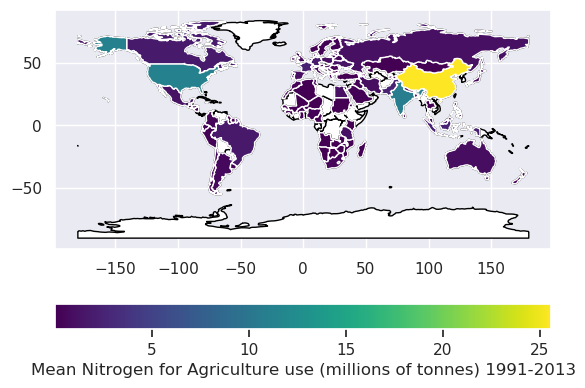

In [37]:
%%capture --no-display
base = world.plot(color = "white", edgecolor = 'black')

gdf_nitrogen.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Nitrogen for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})

plt.show()

### Phosphate

In [38]:
val_country = df_clean.groupby(by="area")["phosphate"].mean()
val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_phos = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [39]:
gdf_phos['value'] = gdf_phos[['value']]/1_000_000

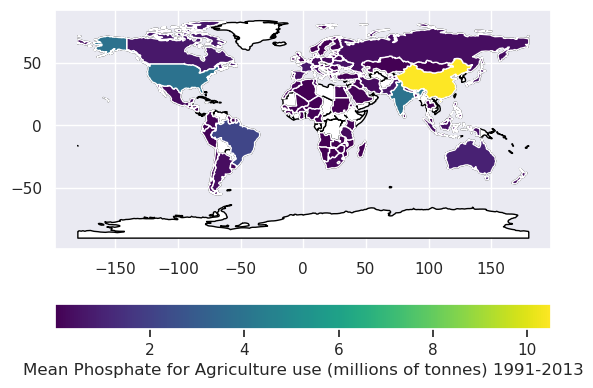

In [40]:
%%capture --no-display

base = world.plot(color = "white", edgecolor = 'black')

gdf_phos.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Phosphate for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Potassium

In [41]:
val_country = df_clean.groupby(by="area")["potassium"].mean()
val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_pot = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [42]:
gdf_pot['value'] = gdf_pot[['value']]/1_000_000

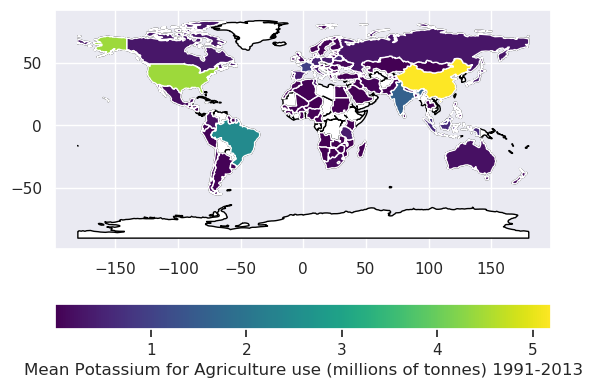

In [43]:
%%capture --no-display

base = world.plot(color = "white", edgecolor = 'black')

gdf_pot.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Potassium for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

## Categorical Anaylsis

#### "Area" and "item" are the only categorical variables

In [44]:
cat_df = pd.DataFrame(df, columns =['area', 'item'])

### "area" EDA:

In [45]:
#Finding the count of countries that are in the Area column:

print ("There are", cat_df['area'].nunique(), "different areas/countries in the dataset")

There are 103 different areas/countries in the dataset


In [46]:
#examining unique values of countries that are in the dataset
cat_df['area'].unique()


array(['Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Belarus', 'Belgium', 'Botswana', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cameroon', 'Canada',
       'Central African Republic', 'Chile', 'China', 'Colombia',
       'Croatia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Eritrea', 'Estonia', 'Finland', 'France',
       'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea',
       'Guyana', 'Honduras', 'Hungary', 'India', 'Indonesia', 'Iran',
       'Iraq', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Kazakhstan',
       'Kenya', 'Latvia', 'Lebanon', 'Lithuania', 'Madagascar', 'Malawi',
       'Malaysia', 'Mali', 'Mauritius', 'Mexico', 'Mongolia', 'Morocco',
       'Mozambique', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand',
       'Nicaragua', 'Niger', 'Nigeria', 'Norway', 'Pakistan', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Qata

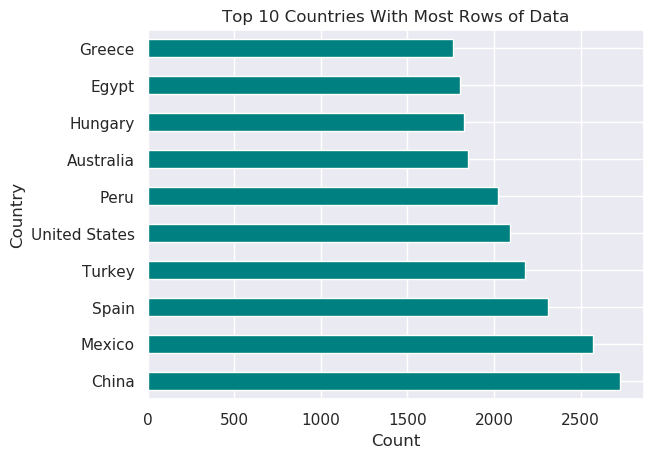

In [47]:
#frequency of each country: 
cat_df['area'].value_counts().head(10).plot(kind='barh', title= 'Top 10 Countries With Most Rows of Data', 
                                            color = 'teal')
plt.ylabel('Country')
plt.xlabel('Count')
plt.show()

#### Countries with most rows of data include China, Mexico, Spain & Turkey

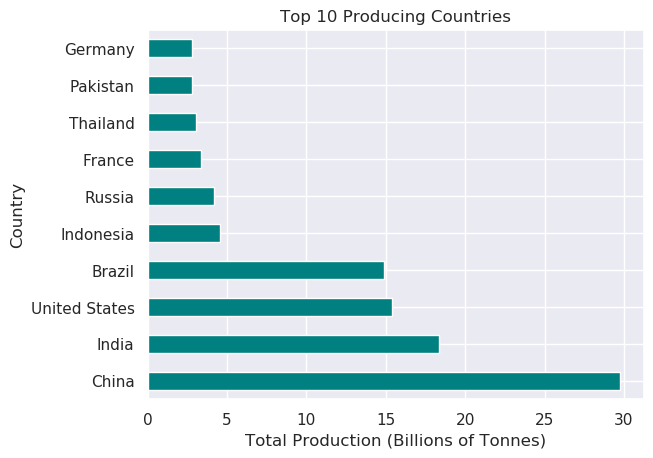

In [48]:
#Total production based on country
p_country = df.production.groupby(df['area']).sum().astype(int).reset_index(name="sum")
p_country = p_country.sort_values(by=['sum'], ascending=False).head(10)


p_country2 = p_country
p_country2['sum'] = p_country2['sum']/1_000_000_000

p_country2.plot(kind='barh', title= 'Top 10 Producing Countries', x=('area'), y = ('sum'), 
                color = 'teal', legend = None)



plt.xlabel('Total Production (Billions of Tonnes)')
plt.ylabel('Country')
plt.show()

#### Countries with most production are China, India, United States and Brazil

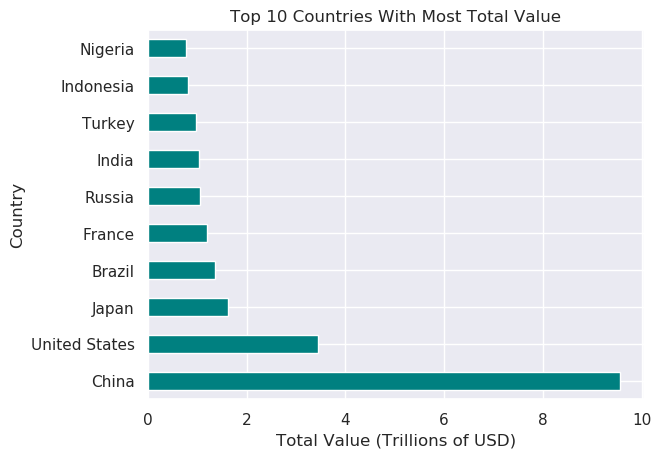

In [49]:
#Total value usd based on country
usd_country = df.total_value_usd.groupby(df['area']).sum().astype(int).reset_index(name="sum")
usd_country = usd_country.sort_values(by=['sum'], ascending=False).head(10)

usd_country2 = usd_country
usd_country2['sum'] = usd_country2['sum']/1_000_000_000_000
usd_country2.plot(kind='barh', title= 'Top 10 Countries With Most Total Value', x=('area'), y = ('sum'), 
                 color = 'teal', legend = None)

plt.ylabel('Country')
plt.xlabel('Total Value (Trillions of USD)')
plt.show()

#### Countries with highest total value USD include China, United States, Japan, and Brazil 

### "Item" EDA

In [50]:
#Finding the count of Items that are in the Item column:

print ("There are", cat_df['item'].nunique(), "different commodities in the dataset")

There are 190 different commodities in the dataset


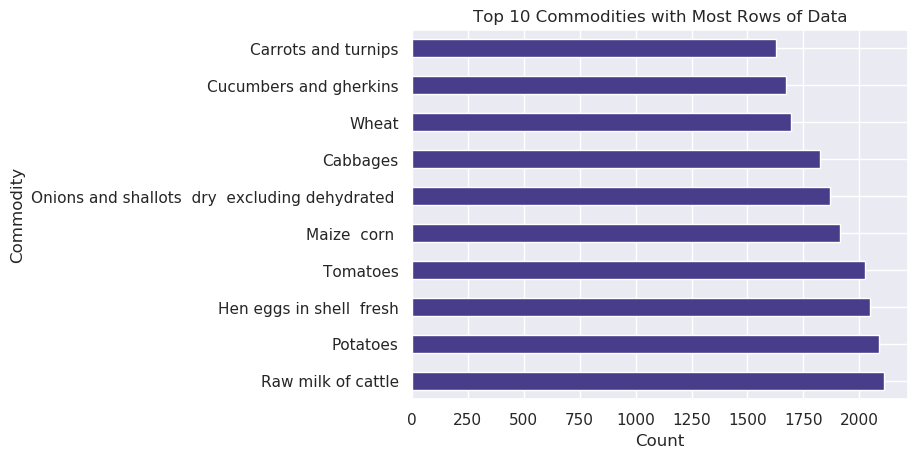

In [51]:
#frequency of each item: 
cat_df['item'].value_counts().head(10).plot(kind='barh', title= 'Top 10 Commodities with Most Rows of Data', 
                                            color = 'darkslateblue')

plt.xlabel('Count')
plt.ylabel('Commodity')
plt.show()

#### Top items with most rows of data are hen eggs in shell fresh, raw milk of acttle, potatoes, tomatoes, maize corn, etc. 

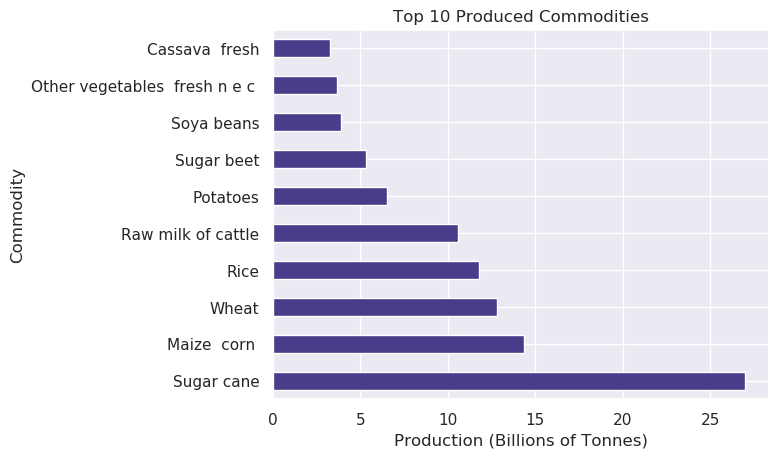

In [52]:
#Total production based on country
I_country = df.production.groupby(df['item']).sum().astype(int).reset_index(name="sum")
I_country = I_country.sort_values(by=['sum'], ascending=False).head(10)

I_country2 = I_country
I_country2['sum'] = I_country2['sum']/1_000_000_000

I_country2.plot(kind='barh', title= 'Top 10 Produced Commodities', x=('item'), y = ('sum'), 
                legend=None, color = 'darkslateblue')

plt.xlabel('Production (Billions of Tonnes)')
plt.ylabel('Commodity')
plt.show()

#### Top produced items include sugar cane, maize corn, wheat and rice

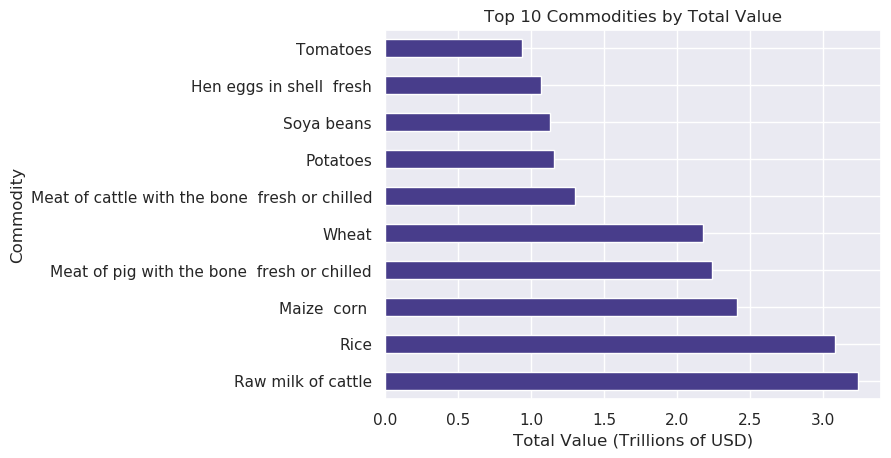

In [53]:
#Total value usd based on Item
usd_item = df.total_value_usd.groupby(df['item']).sum().astype(int).reset_index(name="sum")
usd_item = usd_item.sort_values(by=['sum'], ascending=False).head(10)

usd_item2 = usd_item
usd_item2['sum'] = usd_item2['sum']/1_000_000_000_000


usd_item2.plot(kind='barh', title= 'Top 10 Commodities by Total Value', x=('item'), y = ('sum'), 
               legend = None, color = 'darkslateblue')

plt.xlabel('Total Value (Trillions of USD)')
plt.ylabel('Commodity')
plt.show()

#### Items that have highest total value USD include raw milk of cattle, rice, maize corne and meat of pig with the bone fresh or chilled

### Outlier Analysis


In [54]:
summary =pd.DataFrame(df.describe())
summary

,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd,lat,long
count,113454.000000,1.108840e+05,1.113050e+05,1.090010e+05,1.080210e+05,72779.000000,113454.000000,113454.000000,7.253600e+04,113454.000000,113454.000000
mean,2001.954545,1.337219e+06,1.429205e+06,5.956547e+05,3.933367e+05,987.891786,1021.496219,17.001938,4.636290e+08,24.034191,15.719130
std,6.778856,1.099610e+07,4.353015e+06,1.799397e+06,1.124213e+06,1620.114512,681.223616,7.231138,2.745589e+09,25.584214,60.775976
min,1991.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,51.000000,-3.370000,0.000000e+00,-41.500083,-107.991707
25%,1996.000000,5.789000e+03,4.270000e+04,1.800000e+04,9.286000e+03,226.200000,591.000000,10.330000,6.381282e+06,7.877396,-4.837979
50%,2001.500000,4.205850e+04,2.010000e+05,7.500000e+04,4.900000e+04,451.600000,748.000000,16.960000,3.418865e+07,31.172821,19.999962
75%,2008.000000,2.720000e+05,9.146600e+05,3.273870e+05,1.993220e+05,1089.000000,1485.000000,24.100000,1.806696e+08,42.638426,44.673665
max,2013.000000,7.680904e+08,3.080070e+07,1.425946e+07,9.217027e+06,40039.700000,3240.000000,30.420000,1.791078e+11,64.686314,172.834408


In [55]:
num_df = pd.DataFrame(df, columns =['production', 'nitrogen', 'phosphate', 'potassium', 'value', 'avg_rain','avg_temp', 'total_value_usd'])
num_df.head()

,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd
0,10000.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
1,1200.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
2,3323.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
3,12844.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
4,0.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN


#### Boxplot for numerical data:

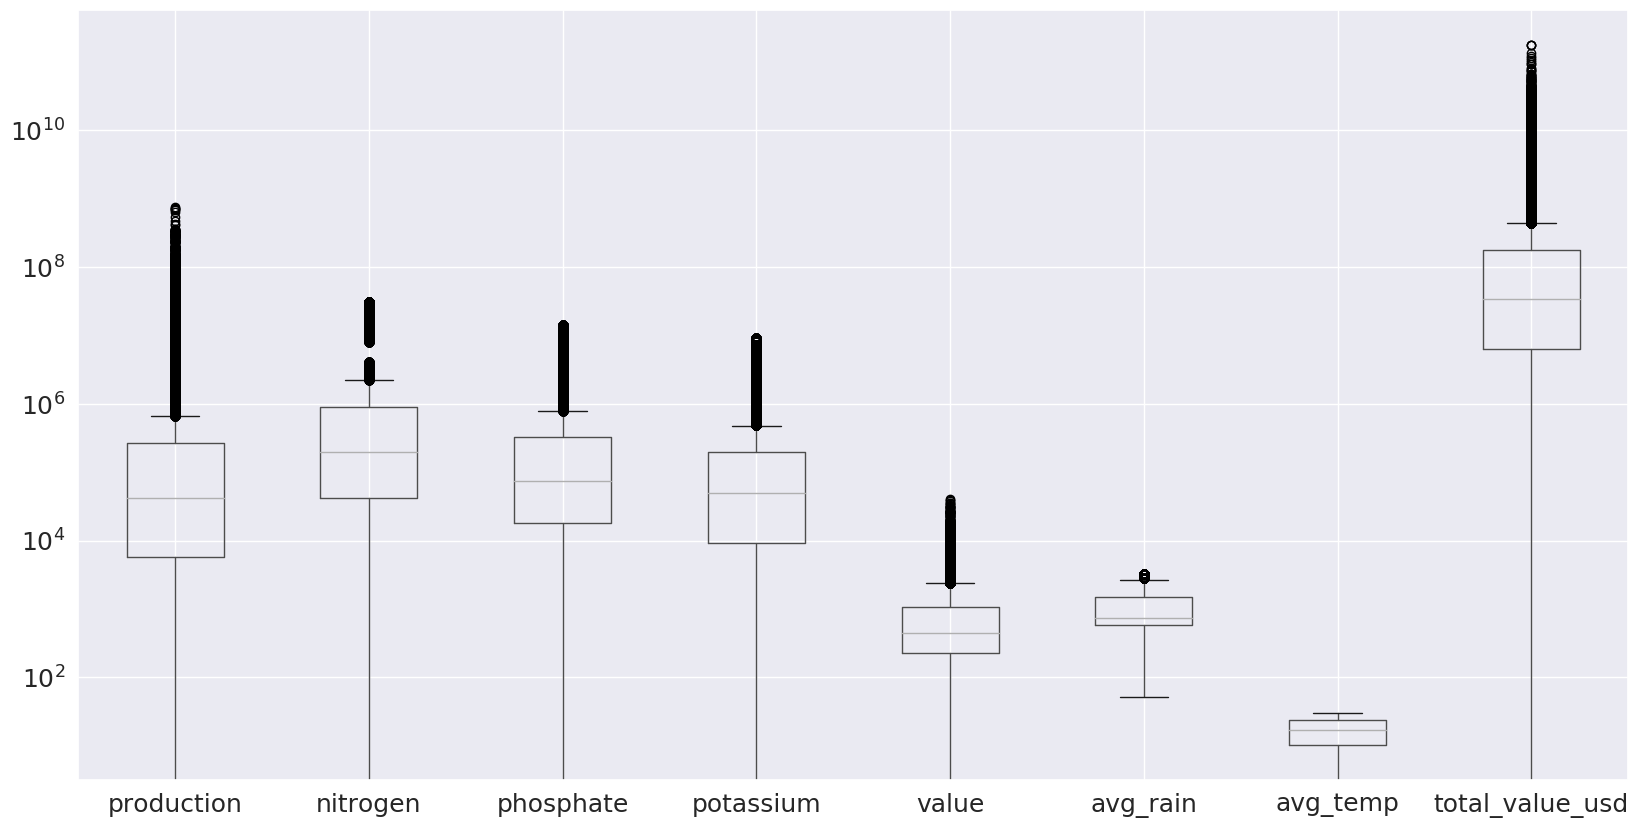

In [56]:
num_df.boxplot(figsize=(20,10), fontsize = 18)
plt.semilogy()
plt.show()

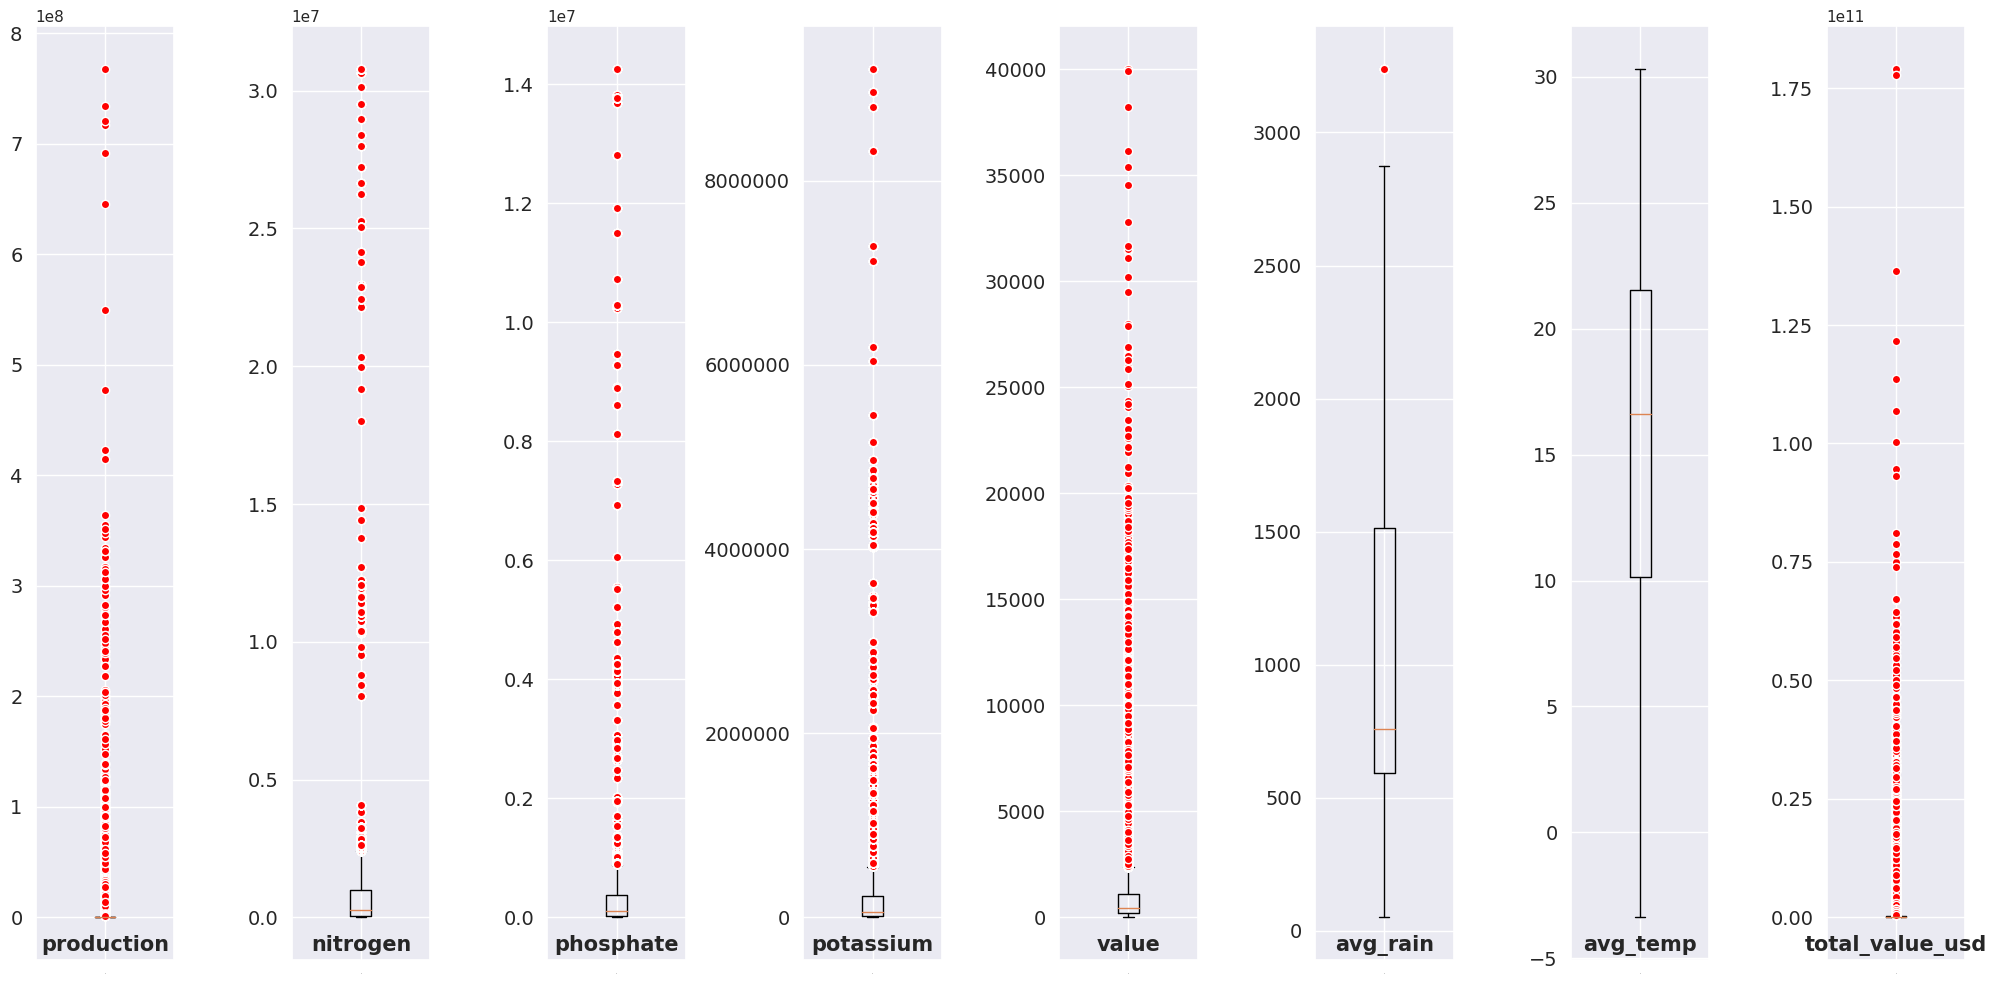

In [57]:
#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

num_df = num_df.dropna()

fig, axs = plt.subplots(1, len(num_df.columns), figsize=(20,10))

for col, ax in enumerate(axs.flat):
    ax.boxplot(num_df.iloc[:,col], flierprops=red_circle)
    ax.set_title(num_df.columns[col], fontsize=15, fontweight='bold', y = 0)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize = 0)
    
plt.tight_layout()
plt.show()

#### Boxplots for each column individually:
Not sure if we want to keep

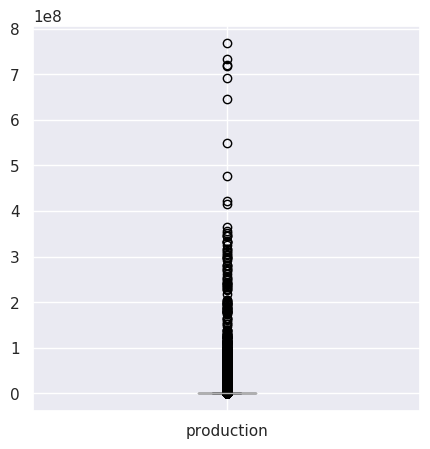

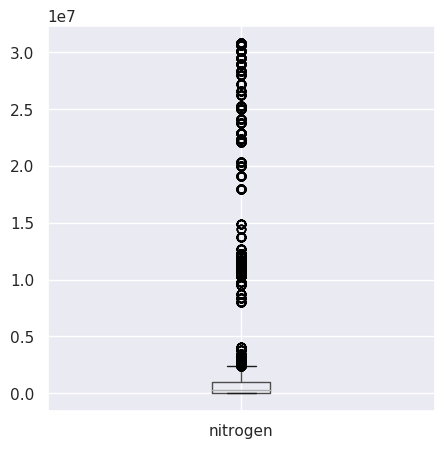

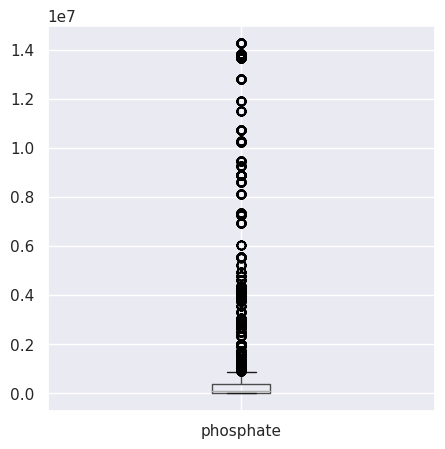

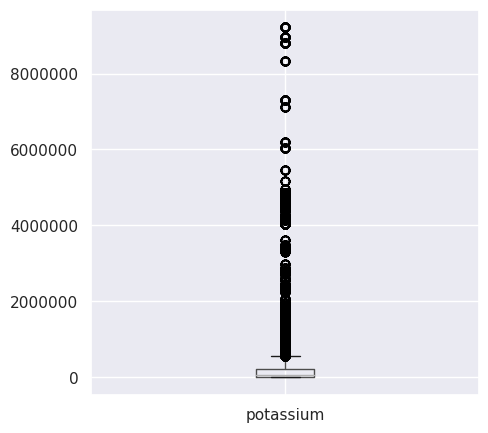

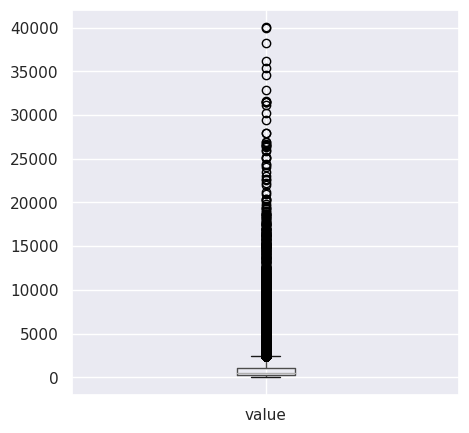

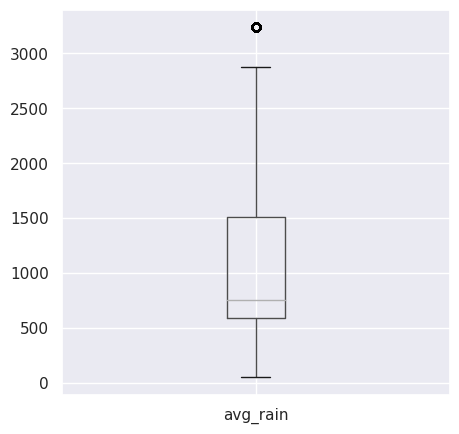

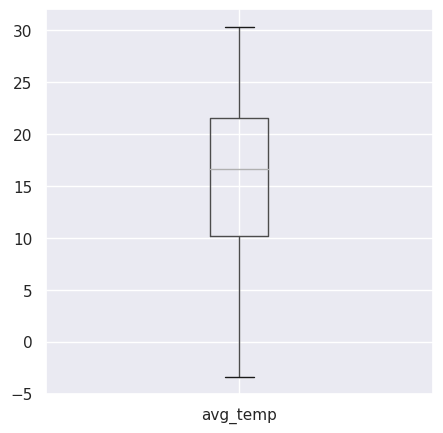

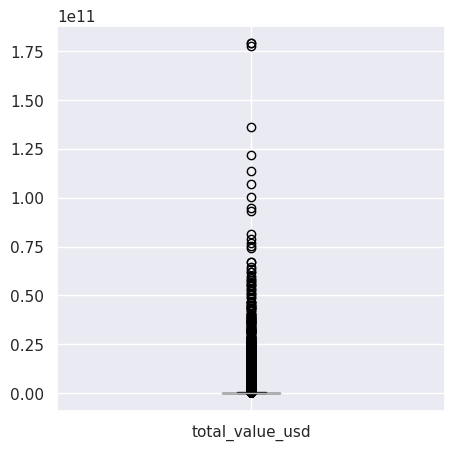

In [58]:
for column in num_df:
    plt.figure(figsize=(5,5))
    num_df.boxplot([column])
    plt.show()

#### It looks like most of the numerical columns have a large amount of outliers. Outliers should be kept considering significant amount of data. Average rain and average temp could possibly be resolved for outliers.

## Data Preparation:
We will not need the production, value, area, or year columns for modeling. Production and value were only used to create total_value_usd, area will be represented numerically through lat and long, and we are not doing any time series forecasting.

In [59]:
df_model = df_clean.drop(['production', 'value', 'area'], axis=1)

### Creating ratio features for the fertilizer columns:

In [60]:
#specifying the fertilizer columns to sum
cols = ['nitrogen', 'phosphate', 'potassium']

#setting up columm for sum:
df_model['fertilizer_sum'] = df_model[cols].sum(axis=1)

#creating ratio columns:

df_model["nitrogen_ratio"] = df_model["nitrogen"]/df_model["fertilizer_sum"]
df_model["phosphate_ratio"] = df_model["phosphate"]/df_model["fertilizer_sum"]
df_model["potassium_ratio"] = df_model["potassium"]/df_model["fertilizer_sum"]

# Drop the old fertilizer variables
df_model = df_model.drop(['nitrogen','phosphate','potassium','fertilizer_sum'], axis=1)

### One hot encode categorical data

In [61]:
cat = df_model[['item']]

ohe = OneHotEncoder(sparse = False).fit(cat)
cat_data = ohe.transform(cat)
cat_df = pd.DataFrame(cat_data, columns = ohe.get_feature_names(['item'])).reset_index(drop = True)

# Join to rest of data
df_model_num = df_model.drop(columns=['item'], axis = 1).reset_index(drop=True)
df_model2 = pd.concat([df_model_num, cat_df], axis = 1)

### Splitting Data

We will split with a 90/5/5 ratio and will keep the random state as 1

In [62]:
# Split training from test and val
y = df_model2['total_value_usd']
X = df_model2.drop(['total_value_usd'], axis = 1)

X_train, X_testval, y_train, y_testval = train_test_split(X, y, train_size = 0.90, random_state = 1)

# Split testing and val
X_test, X_val, y_test, y_val = train_test_split(X_testval, y_testval, train_size = 0.5, random_state = 1)


# Ensure we split correctly
total = df_model.shape[0]

print("Train df size: ", X_train.shape[0], " (", round(X_train.shape[0]/total*100, 2), " percent of the total.)", sep='')
print("Test df size: ", X_test.shape[0], " (", round(X_test.shape[0]/total*100, 2), " percent of the total.)", sep='')
print("Val df size: ", X_val.shape[0], " (", round(X_val.shape[0]/total*100, 2), " percent of the total.)", sep='')

Train df size: 65282 (90.0 percent of the total.)
Test df size: 3627 (5.0 percent of the total.)
Val df size: 3627 (5.0 percent of the total.)


### Set up scaler and imputer for future modeling pipeline

In [70]:
scaler = StandardScaler(with_mean = False)
imputer = SimpleImputer()

# Future Reference
We'll need to create pipelines for each individual model. Here is an example of one for a logistic regression

#### Here you can define hyperparameters for logreg, penalty and C. 

penalty = ['none', 'l1', 'l2']

C = [0.01, 0.1, 1, 10, 100]

#### Then define the model
log_reg = LogisticRegression()



#### Next you'll need to create the pipeline:

log_pipe = Pipeline(steps = [('scaler', scaler), ('imputer', imputer), ('log_reg', log_reg)])

#### Then put your hyperparameters in a dictionary matched to the model hyperparamter name
params = dict(log_reg__C=C,
             log_reg__penalty=penalty)
             
             
#### Fit this model with the training set then predict and calculate our metrics on the validation set.
Fit on the pipeline, so everything is scaled and imputed

#### Then use define cross validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, 
                             random_state=1)

#### Run tuning pipeline 
Note: Randomized search CV may be better, depending on how long we want training to take, also need to make sure CPUs cores match up

log_tuned = GridSearchCV(log_pipe, params, verbose = 10, n_jobs=!)
log_tuned.fit(X_train, y_train)
log_tuned.best_params_

# Modeling

In [66]:
# Try converting training data to sparse matrix
X_train_sparse = scipy.sparse.csr_matrix(X_train.values)

### Baseline Linear Regression

In [71]:
# Create modeling pipeline
clf = Pipeline(steps = [('scaler', scaler), ('imputer', imputer), 
                        ('linreg', LinearRegression())])



linreg = clf.fit(X_train_sparse, y_train)

# Predict
y_pred = linreg.predict(X_test)

In [72]:
%%capture --no-display
# Create ranking deployment

# First fix years issue
results = X_test.copy()
results['year'] = test_year

# Join the predicitons
results['pred'] = y_pred

# Reverse the one hot encoding
reverse_onehot = results.iloc[: ,7:195].idxmax(1)
results2 = results.iloc[:, np.r_[0:7,195:197]]
results2['item'] = pd.Series(reverse_onehot)
results2['item'] = results2['item'].str.replace("item_", "")

results2['group_rank'] = results2.groupby(['lat','long', 'year'])['pred'].rank(method="first").astype(int)
model_rankings = results2.sort_values(by=['lat','long','year','group_rank'])

model_rankings = model_ranking[["lat","long", "year", "item", "group_rank"]]

NameError: name 'test_year' is not defined

In [84]:
%%capture --no-display
# Create test df ranks for calculating metrics

# First fix years issue
test_rank = X_test.copy()
test_rank['year'] = test_year

# Join the predicitons
test_rank['pred'] = y_test

# Reverse the one hot encoding
reverse_onehot = test_rank.iloc[: ,7:195].idxmax(1)
test_rank2 = test_rank.iloc[:, np.r_[0:7,195:197]]
test_rank2['item'] = pd.Series(reverse_onehot)
test_rank2['item'] = test_rank2['item'].str.replace("item_", "")

test_rank2['group_rank'] = test_rank2.groupby(['lat','long', 'year'])['pred'].rank(method="first").astype(int)
test_rank_final = test_rank2.sort_values(by=['lat','long','year','group_rank'])

test_rank_final = test_rank_final[["lat","long", "year", "item", "group_rank"]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [85]:
test_rank_final

,lat,long,year,item,group_rank
45004,-41.500083,172.834408,1991,Peaches and nectarines,1
45014,-41.500083,172.834408,1991,Strawberries,2
45027,-41.500083,172.834408,1992,Currants,1
45081,-41.500083,172.834408,1993,Plums and sloes,1
45105,-41.500083,172.834408,1994,Lemons and limes,1
...,...,...,...,...,...
55196,64.686314,97.745306,2010,Grapes,2
55128,64.686314,97.745306,2011,Cabbages,1
55222,64.686314,97.745306,2012,Buckwheat,1
55247,64.686314,97.745306,2012,Rye,2


# Tensorflow Stuff:

We should be able to delete the tensor flow stuff unless someone wants to keep trying on it

#### Preparing the dataframe to to convert to tensor:

In [147]:
numeric_feature_names = ['avg_rain', 'avg_temp', 'total_value_usd',  'lat', 'long', 'nitrogen_ratio', 'phosphate_ratio', 'potassium_ratio']
numeric_features = df_model[numeric_feature_names]
numeric_features.head()

,avg_rain,avg_temp,total_value_usd,lat,long,nitrogen_ratio,phosphate_ratio,potassium_ratio
122,1485.0,16.05,4610000.0,41.000028,19.999962,0.850755,0.087759,0.061487
125,1485.0,16.05,10508523.0,41.000028,19.999962,0.850755,0.087759,0.061487
144,1485.0,16.05,42742644.0,41.000028,19.999962,0.850755,0.087759,0.061487
145,1485.0,16.05,75723664.0,41.000028,19.999962,0.850755,0.087759,0.061487
148,1485.0,16.05,31275000.0,41.000028,19.999962,0.850755,0.087759,0.061487


In [ ]:
np.array(numeric_features)

array([[1.48500000e+03, 1.60500000e+01, 4.61000000e+06, ...,
        8.50754612e-01, 8.77585243e-02, 6.14868642e-02],
       [1.48500000e+03, 1.60500000e+01, 1.05085230e+07, ...,
        8.50754612e-01, 8.77585243e-02, 6.14868642e-02],
       [1.48500000e+03, 1.60500000e+01, 4.27426440e+07, ...,
        8.50754612e-01, 8.77585243e-02, 6.14868642e-02],
       ...,
       [6.57000000e+02, 1.97600000e+01, 3.47046600e+07, ...,
        5.05365854e-01, 3.46341463e-01, 1.48292683e-01],
       [6.57000000e+02, 1.97600000e+01, 1.76179750e+06, ...,
        5.05365854e-01, 3.46341463e-01, 1.48292683e-01],
       [6.57000000e+02, 1.97600000e+01, 2.37501800e+07, ...,
        5.05365854e-01, 3.46341463e-01, 1.48292683e-01]])

In [ ]:
num_data = tf.convert_to_tensor(numeric_features)

#### Building Recommender Model:

In [ ]:
df_model =model_df.map(lambda x: {
    "item": x["item"],
    "avg_rain": x["avg_rain"],
    "avg_temp": x["avg_temp"],
    "total_value_usd": x["total_value_usd"],
    "lat": x["lat"],
    "long": x["long"],
    "nitrogen_ratio": x["nitrogen_ratio"],
     "phosphate_ratio": x["phosphate_ratio"],
    "potassium_ratio": x["potassium_ratio"]
}) 

NameError: name 'model_df' is not defined

In [ ]:
tf.random.set_seed(508)
shuffled = df_model.shuffle(100_000, seed=508, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000_.take(20_000)

SyntaxError: invalid token (<ipython-input-149-140f76a02a0d>, line 5)